## Time to get your hands dirty.  The transient Universe

1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using `emcee` perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.stats import uniform

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[7,5]

### Data
Load the data and have a quick look at them.

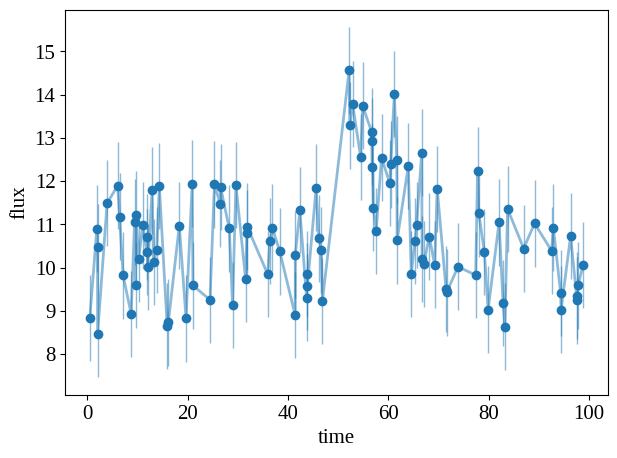

In [3]:
data=np.load('transient.npy')

time=data[:,0]
flux=data[:,1]
err=data[:,2]

plt.scatter(time, flux)
plt.errorbar(time, flux, err, lw=2, elinewidth=1, alpha=0.5)
plt.xlabel("time")
plt.ylabel("flux")
plt.show()

### Model
Define now the model that will use to perform the analysis:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$


Try to fit *by hand* the model to the data, in order to have a first estimation of the parameters.

In [4]:
def model(par, time):
    b, A, t_0, alpha = par
    y=np.empty(len(time))
    for i in range(len(time)):
        if time[i]<t_0:
            y[i]=b
        else:
            y[i]=b + A * np.exp(-alpha*(time[i]-t_0)) 
    return y

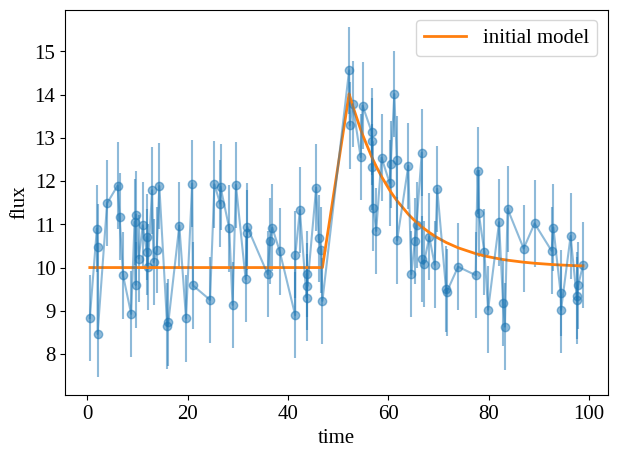

In [6]:
b, A, t_0, alpha = 10, 5, 50, 0.1
par = [b, A, t_0, alpha]

# fit the model with arbitrary parameter to search reasonably initial conditions
flux_model = model(par, time)

plt.scatter(time, flux, alpha=0.5)
plt.errorbar(time, flux, err, alpha=0.5)
plt.plot(time, flux_model, label='initial model', lw=2)
plt.legend()
plt.ylabel('flux')
plt.xlabel('time')
plt.show()

Define the ingredients of the MCMC, in particular the log Likelihood, the priors ($b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\alpha\in \mathrm{Uniform}[e^{-5},e^5]$) and the posterior; then run the MCMC

In [7]:
def logLikelihood(par, time, flux, err):
    b, A, t_0, alpha = par
    Model_y = model(par, time)
    return - 0.5 * np.sum((flux-Model_y)**2/(err**2))

def logPrior(par):
    b, A, t_0, alpha = par
    if 0 < b < 50 and 0 < A < 50 and 0 < t_0 < 100 and np.exp(-5) < alpha < np.exp(5):
        return np.log(1/alpha)
    return -np.inf

def logPosterior(par, time, flux, err):
    lp = logPrior(par)
    if np.isfinite(lp):
        return lp + logLikelihood(par, time, flux, err)
    return lp

In [11]:
ndim = 4  # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
burn = 2000  # "burn-in" period to let chains stabilize
nsteps = 25000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(123)
starting_guesses = par + np.random.randn(nwalkers, ndim)/100

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=[time, flux, err])
sampler.run_mcmc(starting_guesses, nsteps, progress=True)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

100%|██████████████████████████████████████████████████████████████████| 25000/25000 [00:58<00:00, 430.40it/s]

done


In [12]:
print(starting_guesses)

[[ 9.98914369  5.00997345 50.00282978  0.08493705]
 [ 9.994214    5.01651437 49.97573321  0.09571087]
 [10.01265936  4.9913326  49.99321114  0.09905291]
 [10.0149139   4.99361098 49.99556018  0.09565649]
 [10.0220593   5.02186786 50.01004054  0.10386186]
 [10.00737369  5.01490732 49.99064166  0.11175829]
 [ 9.98746119  4.99362248 50.00907105  0.08571319]
 [ 9.99859931  4.99138245 49.99744381  0.07201411]
 [ 9.98228467  4.99300123 50.00927462  0.09826364]
 [10.00002846  5.00688223 49.99120464  0.10283627]
 [ 9.99194633  4.98272331 49.996091    0.10573806]
 [10.00338589  4.9998817  50.02392365  0.10412912]
 [10.00978736  5.02238143 49.98705915  0.08961212]
 [10.01743712  4.99201937 50.00029683  0.11069316]
 [10.00890706  5.01754886 50.01495644  0.11069393]
 [ 9.99227291  5.00794863 50.00314272  0.08673735]
 [10.01417299  5.00807237 50.0004549   0.09766908]
 [ 9.98801699  5.00199524 50.00468439  0.09168845]
 [10.01162204  4.98902797 49.978769    0.11039727]
 [ 9.99596634  4.9987397  49.99

In [13]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain

(20, 25000, 4)
(460000, 4)


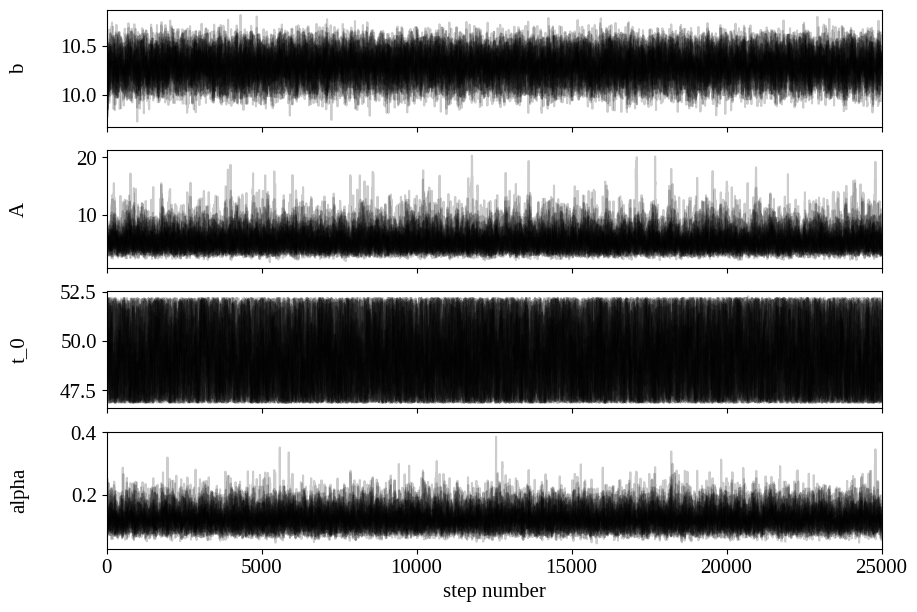

In [14]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["b","A","t_0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.2, color = 'black')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

The MCMC worked; check the start of the chain to better estimate the burn-in period and the autocorrelation lenght.

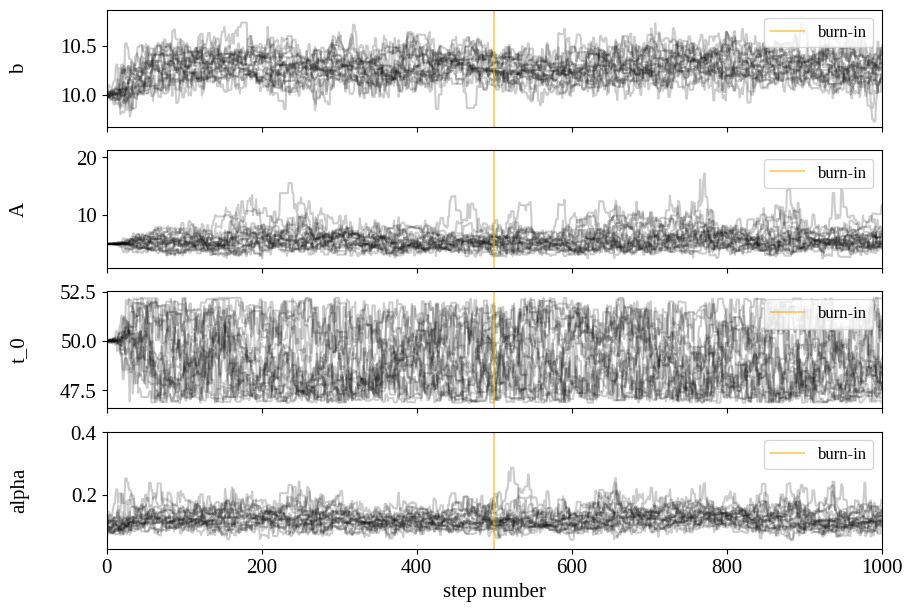

In [15]:
burnin = 500   # remove the first points

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["b","A","t_0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.2, color = 'black')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axvline(burnin, color='orange', alpha=0.5, label='burn-in')
    ax.legend(loc='upper right', fontsize="12")

plt.xlim(0, 1000)
axes[-1].set_xlabel("step number");

In [16]:
tau = sampler.get_autocorr_time()
print(tau)

[58.31367801 78.7984839  76.40499041 63.90136932]


In [17]:
corr_time = int(max(tau))

flat_samples = sampler.get_chain(discard=burnin, thin=corr_time, flat=True)
print(flat_samples.shape)

(6280, 4)


### Corner plot

At the end we are left with a small fraction of the points estimated. Let's make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles.

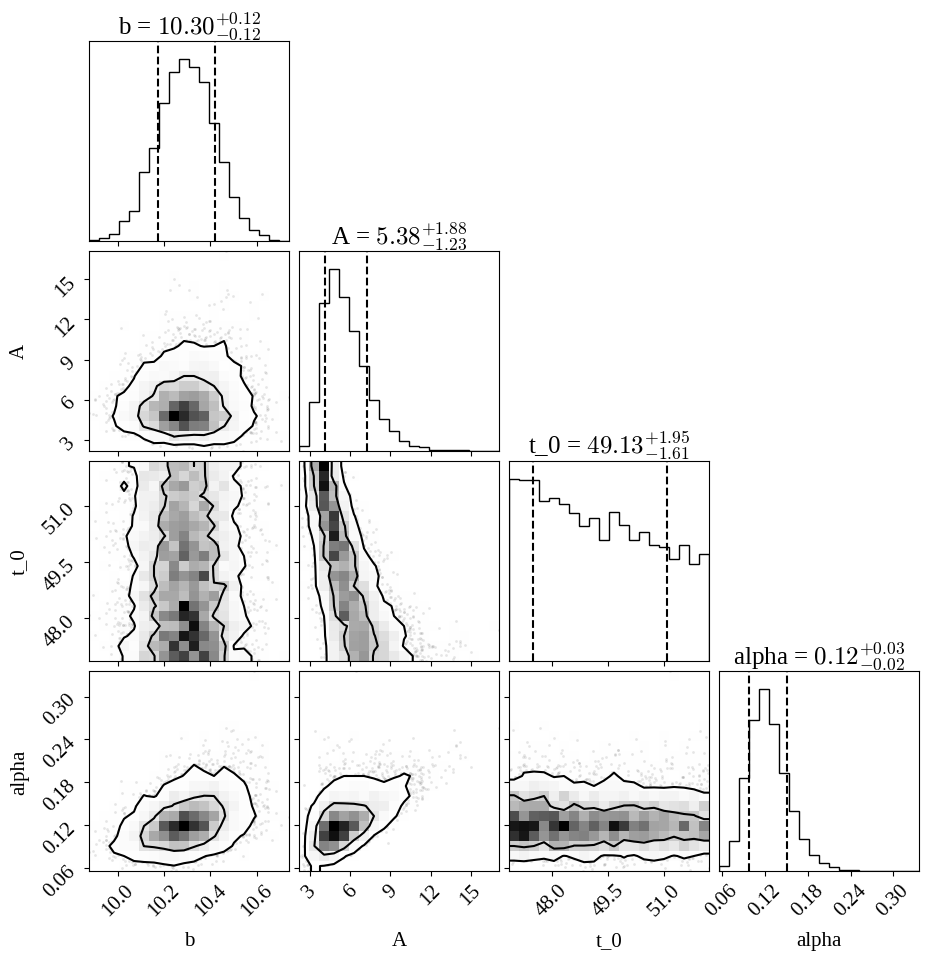

In [18]:
import corner

fig = corner.corner(flat_samples, labels=labels, levels=[0.68,0.95], quantiles=[0.16, 0.84], show_titles=True)

### Posterior spread of the model

Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. These are showing the posterior spread of model.

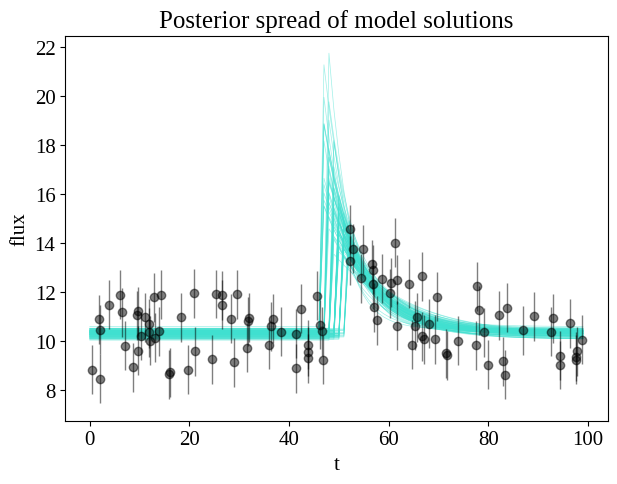

In [32]:
#choose 100 random sample
samples_100 = flat_samples[np.random.choice(range(len(flat_samples)), 100)]

t = np.linspace(0, 100, 100)
flux_mcmc = np.array([model(par, t) for par in samples_100])

for i in range(len(flux_mcmc)):
    plt.plot(flux_mcmc[i], alpha=0.5, color='turquoise', lw=0.5)
    plt.title('Posterior spread of model solutions')
    plt.xlabel('t')
    plt.ylabel('flux')
    
plt.errorbar(time, flux, err, lw=2, elinewidth=1, fmt='o', color='black', alpha=0.5)
plt.show()

The model seems to be consistent with the data. Let's estimate the parameters by considering the median and 90% credible region of the marginalized distribution.

In [27]:
median=np.empty(ndim)
q_95=np.empty(ndim)
q_05=np.empty(ndim)

for i in range(ndim):
    median[i]=np.median(flat_samples[:, i])
    q_95[i]=np.quantile(flat_samples[:, i], 0.95)
    q_05[i]=np.quantile(flat_samples[:, i], 0.05)
    
    up = q_95[i]-median[i]        
    low = median[i]-q_05[i]
    
    print(labels[i], '=', str(round(median[i],2)),'+', str(round(up,2)), '-', str(round(low,2)))

b = 10.3 + 0.2 - 0.2
A = 5.38 + 3.48 - 1.78
t_0 = 49.13 + 2.71 - 2.05
alpha = 0.12 + 0.05 - 0.04


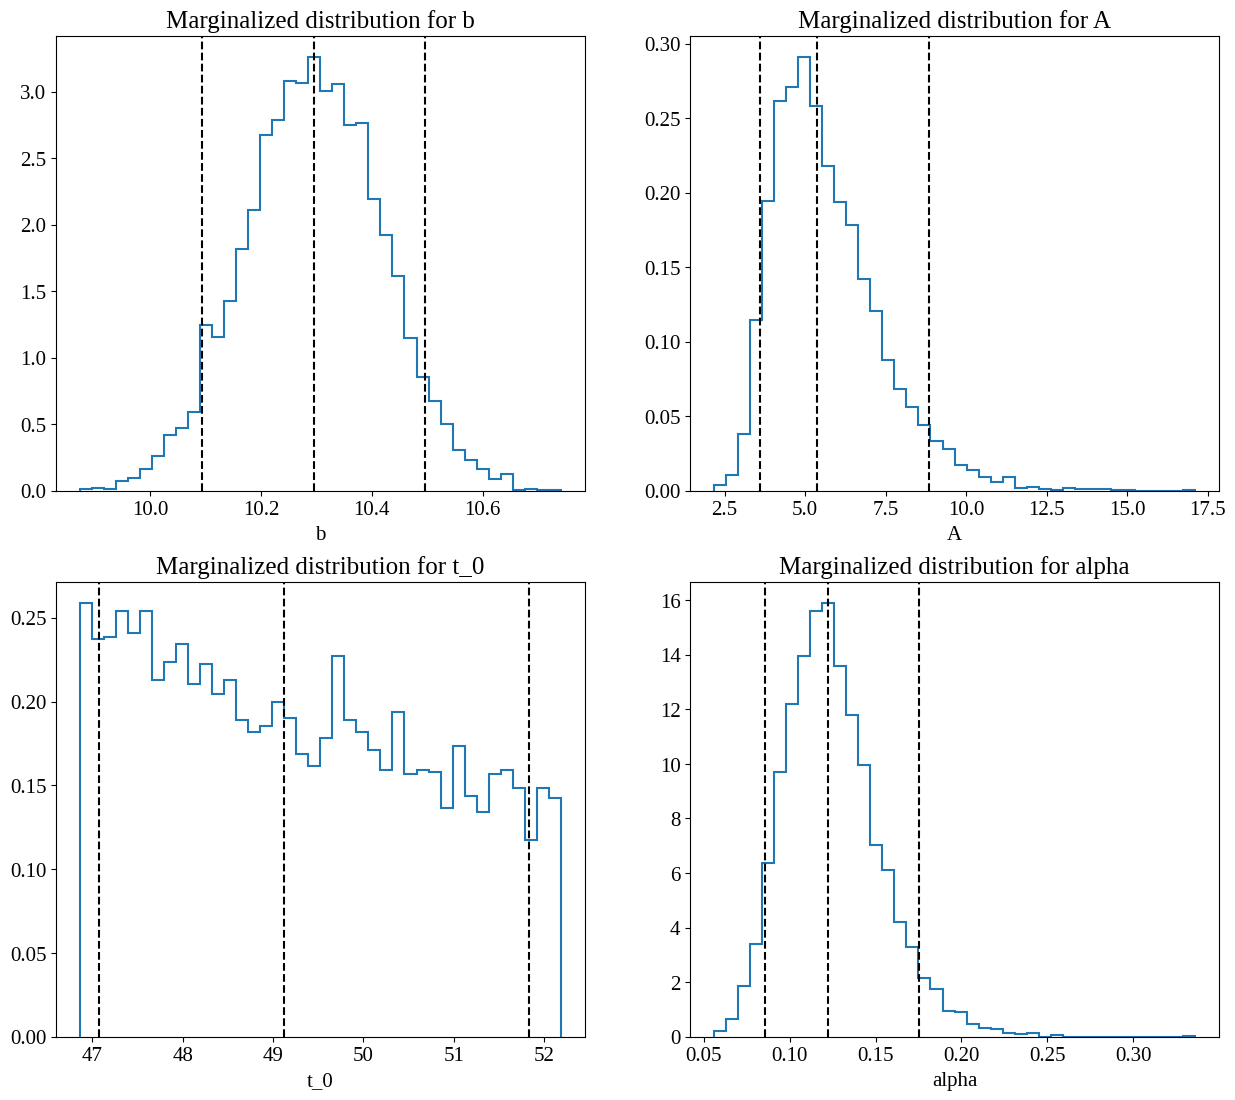

In [31]:
fig, ax = plt.subplots(2, 2, figsize = (15, 13))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]

for a,i in zip(axs, range(ndim)):
    a.hist(flat_samples[:,i], bins=40, histtype='step', density=True, lw=1.5)
    a.axvline(median[i], color='black', linestyle='--')
    a.axvline(q_95[i], color='black', linestyle='--')
    a.axvline(q_05[i], color='black', linestyle='--')
    
    a.set_title('Marginalized distribution for '+ labels[i])
    a.set_xlabel(labels[i])

plt.show()